C:\Users\mathp\AppData\Local\Temp\ipykernel_15208\2523385844.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im1Color = imageio.imread(imFileName)


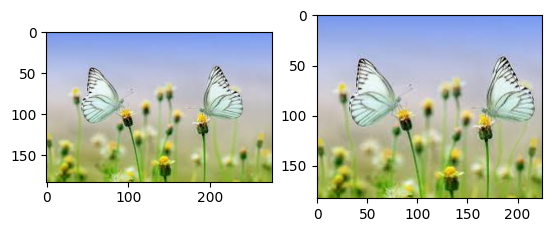

In [6]:
import numpy as np
from scipy import misc
import imageio
import matplotlib.pyplot as plt

# imFileName = r'E:\Data\SeamCarving\Photoes\two_butterflies.jpg'
imFileName = r'two-butterfly.jpg'
im1Color = imageio.imread(imFileName)

# im1Color = misc.imresize(im1Color, .5)
im1Color = np.double(im1Color) / 255.0
im1ColorOrig = im1Color.copy()
colReduction = 50

for seamNo in range(colReduction):

    im1 = np.dot(im1Color[...,:3], [0.2989, 0.5870, 0.1140])
    im1Size = im1.shape

    Ix, Iy = np.gradient(im1)
    # Ix[:,0]=2; Ix[:,-1]=2;
    # Iy[0,:]=2; Iy[-1,:]=2;

    eI = np.abs(Ix) + np.abs(Iy)

    # Vertical Seams
    M = eI.copy()
    seamPath = np.ones(im1Size)
    seamPath[0,:] = np.arange(1, im1Size[1]+1)

    for i in range(1, im1Size[0]):
        for j in range(im1Size[1]):
            if j == 0:
                mojaverha = np.arange(j, j+2)
                decIdx = 0
            elif j == im1Size[1]-1:
                mojaverha = np.arange(j-1, j+1)
                decIdx = 1
            else:
                mojaverha = np.arange(j-1, j+2)
                decIdx = 1
            
            val, idx = np.min(M[i-1, mojaverha]), np.argmin(M[i-1, mojaverha])
            M[i,j] = M[i,j] + val
            seamPath[i,j] = j + (idx - decIdx)
    
    optSeamPath = np.zeros(im1Size[0], dtype=int)
    val, idx = np.min(M[-1,:]), np.argmin(M[-1,:])
    optSeamPath[-1] = idx
    for i in range(im1Size[0]-2, -1, -1):
        optSeamPath[i] = seamPath[i+1, optSeamPath[i+1]]

    for i in range(im1Size[0]):
        im1Color[i,optSeamPath[i],0] = 1.0

    for i in range(im1Size[0]):
        im1Color[i, optSeamPath[i]:-1, :] = im1Color[i, optSeamPath[i]+1:, :]

    im1Color = im1Color[:, :-1, :]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(im1ColorOrig)
axs[1].imshow(im1Color)

In [4]:
# imageio.imwrite(outputFileName, im1Color)
print(im1ColorOrig.shape, im1Color.shape)

(660, 564, 3) (660, 514, 3)


In [5]:
# outputFileName = '{}_c{}.jpg'.format(imFileName[:-4], colReduction)
# imageio.imwrite(outputFileName, im1Color)

In [14]:
import numpy as np
from scipy.ndimage import gaussian_filter

def energy_map(image):
    gray_image = np.mean(image, axis=2)
    dx, dy = np.gradient(gray_image)
    return np.abs(dx) + np.abs(dy)

def find_seam(energy_map):
    M = energy_map.copy()
    for i in range(1, M.shape[0]):
        for j in range(M.shape[1]):
            if j == 0:
                M[i, j] += np.min(M[i-1, j:j+2])
            else:
                M[i, j] += np.min(M[i-1, j-1:j+2])
    seam = np.zeros(M.shape[0], dtype=int)
    last_idx = np.argmin(M[-1])
    for i in range(M.shape[0]-1, -1, -1):
        seam[i] = last_idx
        if i > 0:
            if last_idx == 0:
                last_idx = np.argmin(M[i-1, last_idx:last_idx+2])
            else:
                last_idx = last_idx - 1 + np.argmin(M[i-1, last_idx-1:last_idx+2])
    return seam

def remove_seam(image, seam):
    H, W, _ = image.shape
    new_image = np.zeros((H, W-1, 3))
    for i in range(H):
        new_image[i] = np.delete(image[i], seam[i], axis=0)
    return new_image

def seam_carving(image, size):
    for _ in range(size):
        e_map = energy_map(image)
        seam = find_seam(e_map)
        image = remove_seam(image, seam)
        image = image.astype(int)
    return image

In [24]:
# Example usage
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray

image = io.imread('two-butterfly.jpg')
gray_image = rgb2gray(image)
new_image = seam_carving(image, 100) # Reduce width by 100 pixels

In [22]:
image[0,0,0], new_image[0,0,0]

(116, 116.0)

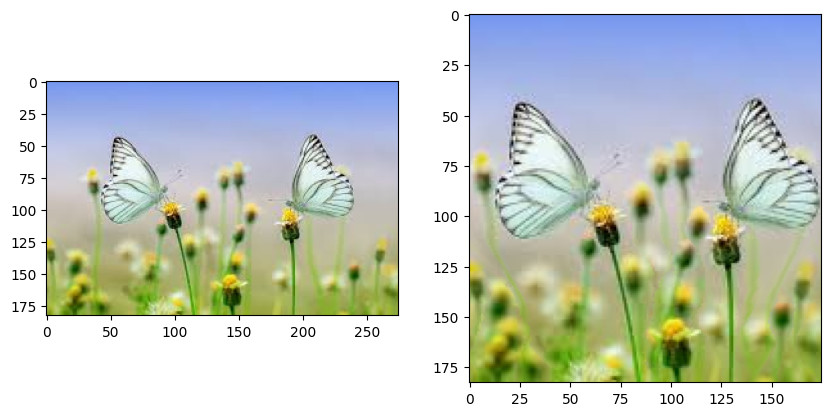

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(new_image.astype(int))

In [11]:
# !pip install scikit-image